In [1]:
# Python set up
import warnings
import itertools
import datetime
from datetime import datetime
from pandas import read_csv
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 
import seaborn as sns  
sns.set(style="whitegrid")

In [7]:
df = pd.read_csv("sample_machine/industrial production.csv")

In [8]:
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3336
1,1939-02-01,3.3591
2,1939-03-01,3.4354
3,1939-04-01,3.4609
4,1939-05-01,3.4609


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1018 non-null   object 
 1   IPG2211A2N  1018 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.0+ KB


## Convert index to time series 

In [10]:
df.index = pd.to_datetime(df.DATE)
df = df.drop(['DATE'], axis=1)

In [12]:
df.index

DatetimeIndex(['1939-01-01', '1939-02-01', '1939-03-01', '1939-04-01',
               '1939-05-01', '1939-06-01', '1939-07-01', '1939-08-01',
               '1939-09-01', '1939-10-01',
               ...
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01'],
              dtype='datetime64[ns]', name='DATE', length=1018, freq=None)

In [13]:
df.columns =['Production']

## Plot the data

Text(0.5, 0, 'year')

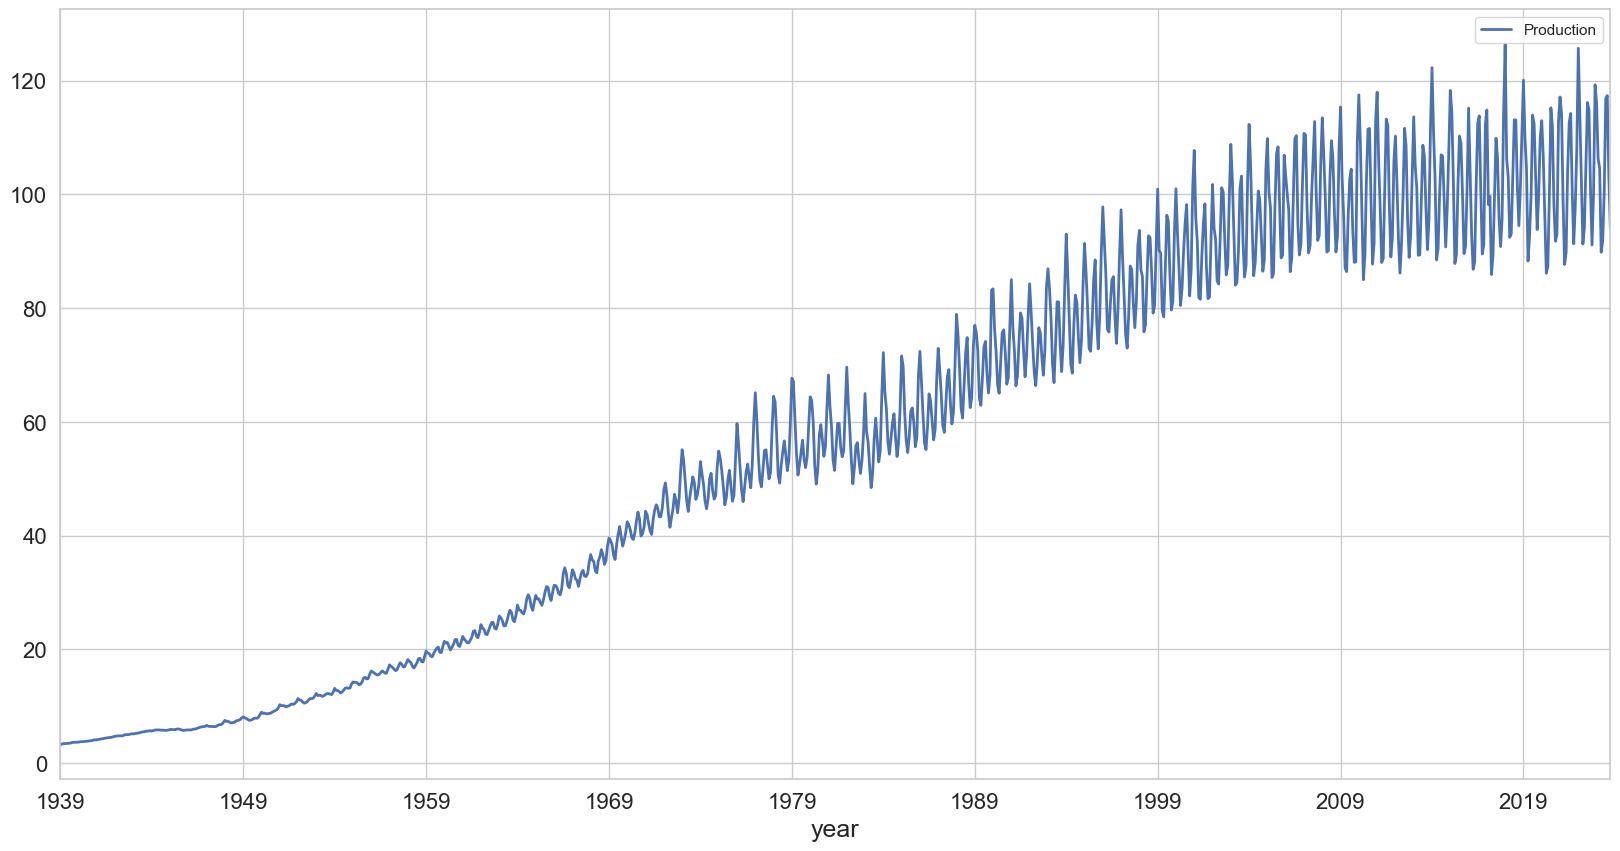

In [14]:
df.plot(figsize=(20,10), linewidth=2, fontsize=16)
plt.xlabel('year', fontsize=18)

## Decompose with Statsmdoels

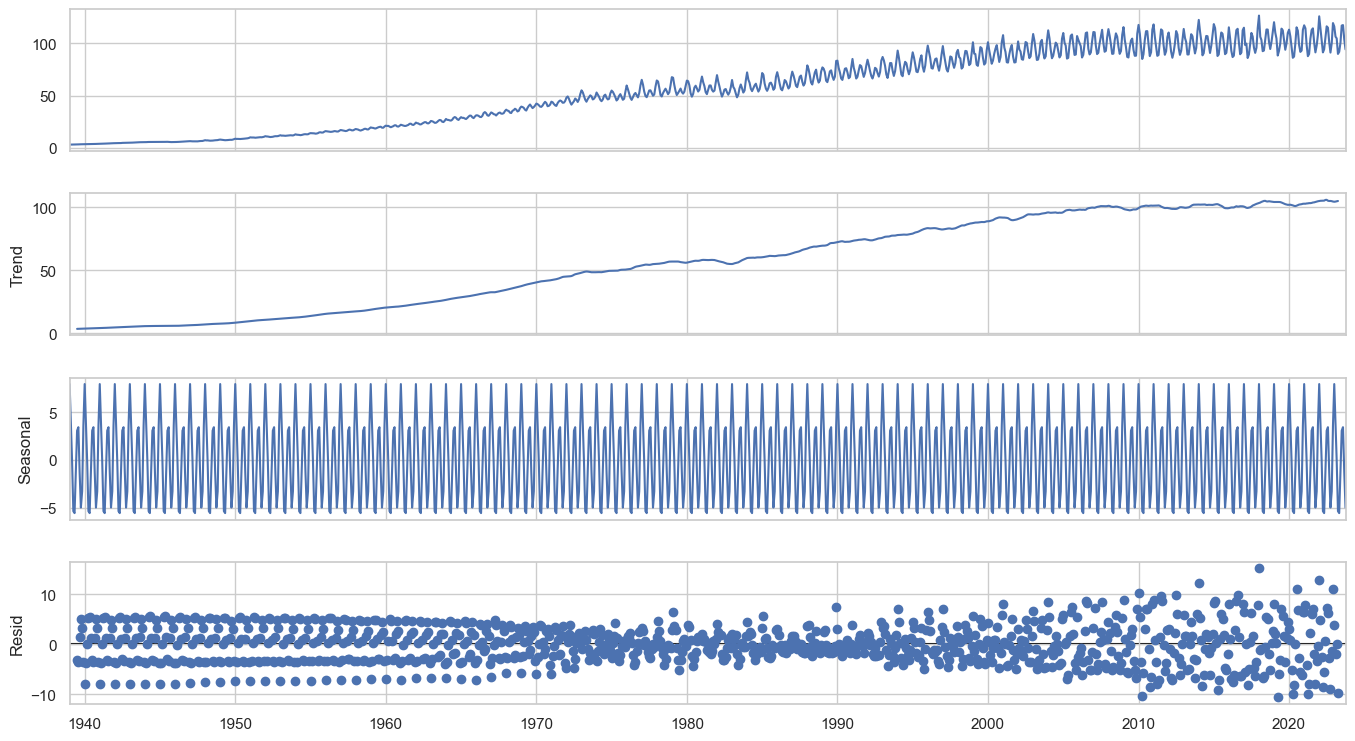

In [16]:
decomposition = seasonal_decompose(df, model='additive');
fig = decomposition.plot();
fig.set_size_inches(15, 8);

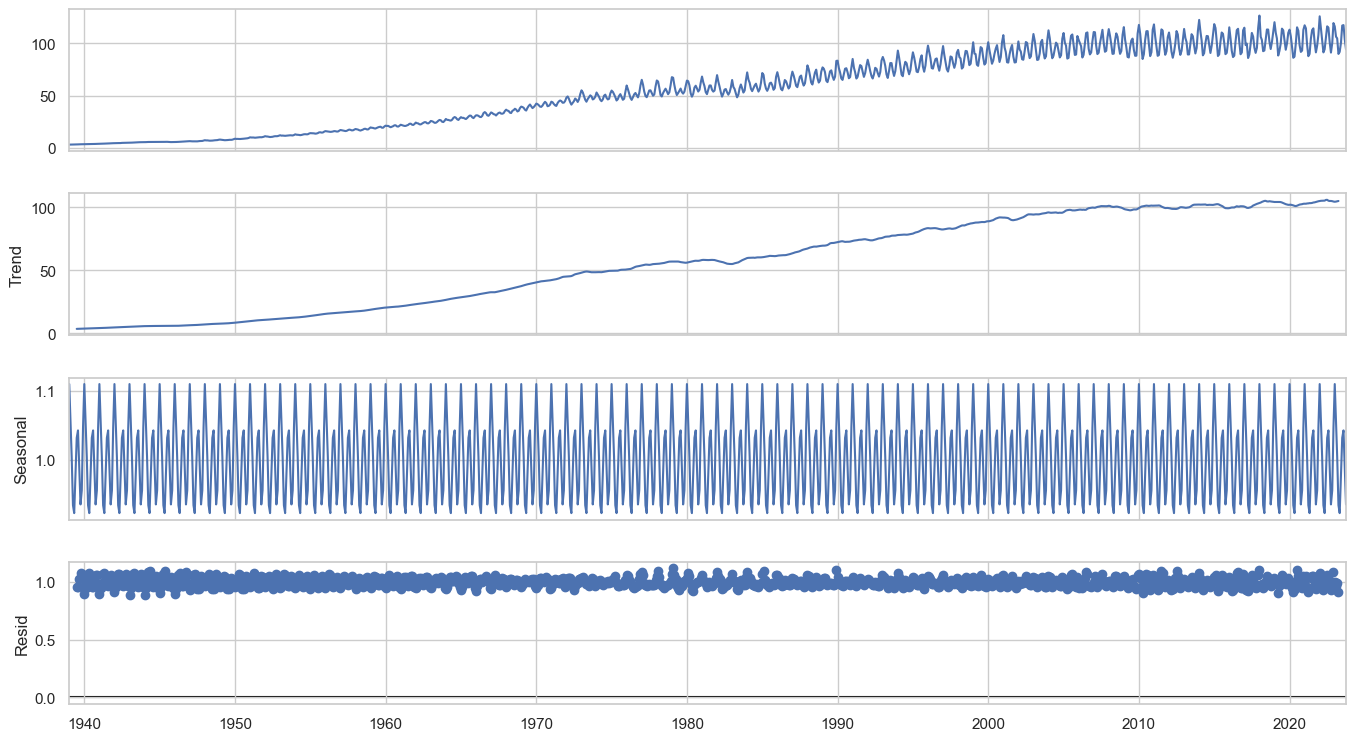

In [17]:
decomposition = seasonal_decompose(df, model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(15, 8)

## An ARIMA (AutoRegressive Integrated Moving Average) model is a class of 

The statsmodels library provides the capability to fit an ARIMA model. An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters. The model is prepared on the training data by calling the fit() function. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire dataset and review the residual errors.

First, we fit an ARIMA(5,1,0) model. This sets the lag value (p) to 5 for autoregression, uses a difference order d of 1 to make the time series stationary, and uses a moving average model q of 0.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

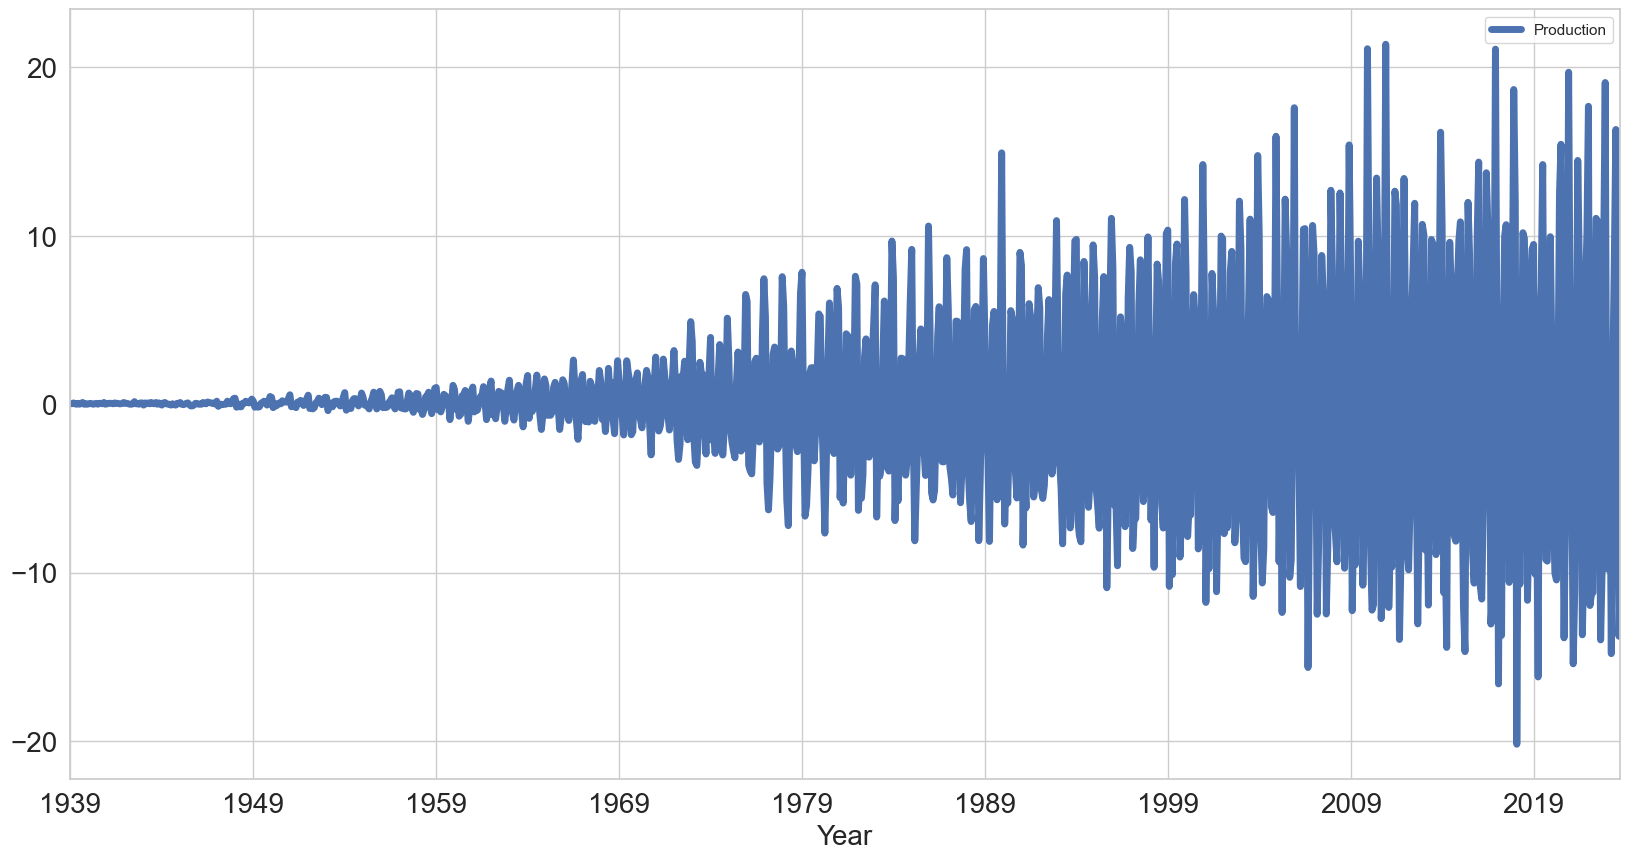

In [22]:
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

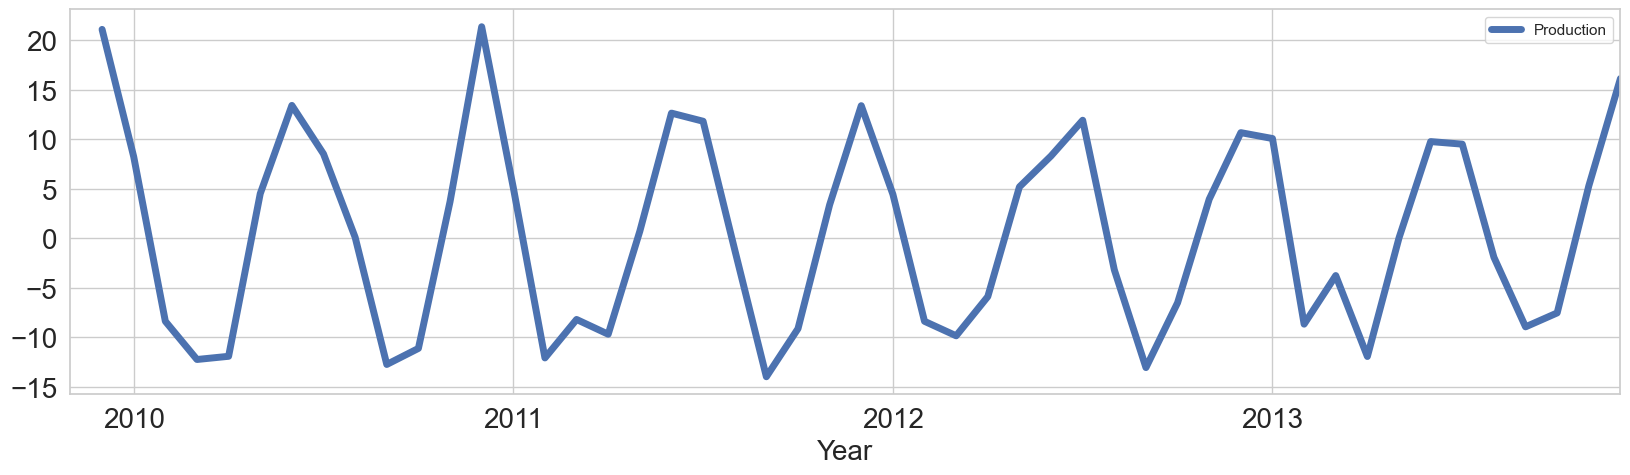

In [23]:
# reduce data to get a better picture of the distribution
df2 = df.iloc[850:900] 
df2.diff().plot(figsize=(20,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

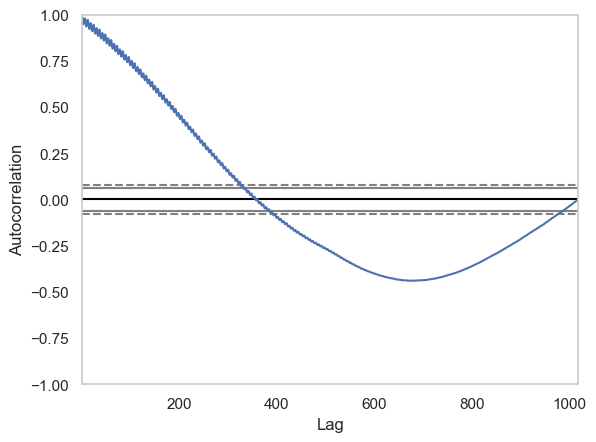

In [24]:
autocorrelation_plot(df);

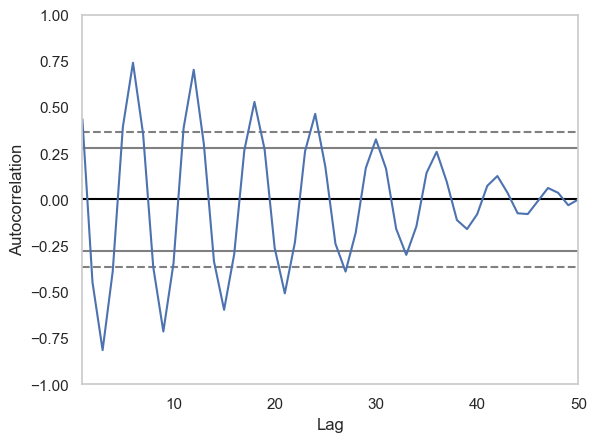

In [25]:
autocorrelation_plot(df2);

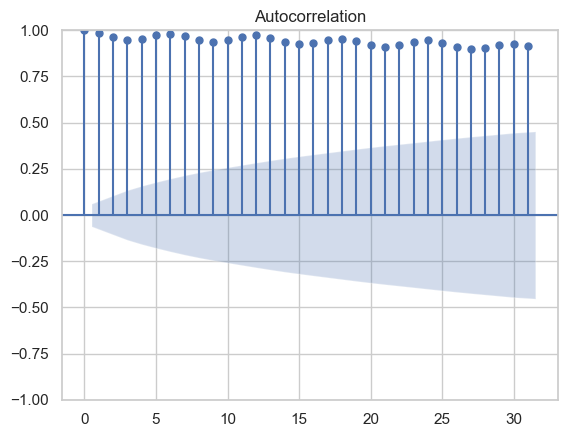

In [26]:
plot_acf(df);

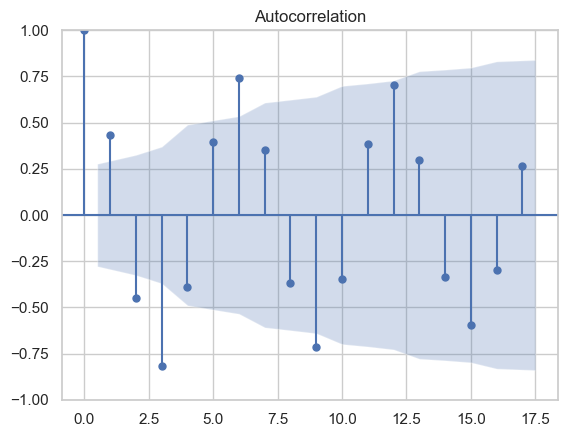

In [27]:
plot_acf(df2);

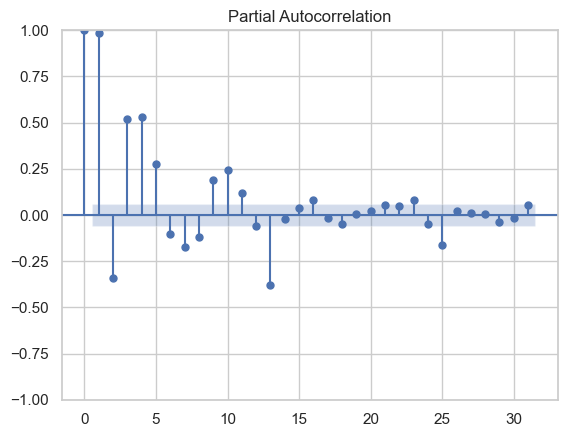

In [28]:
plot_pacf(df);


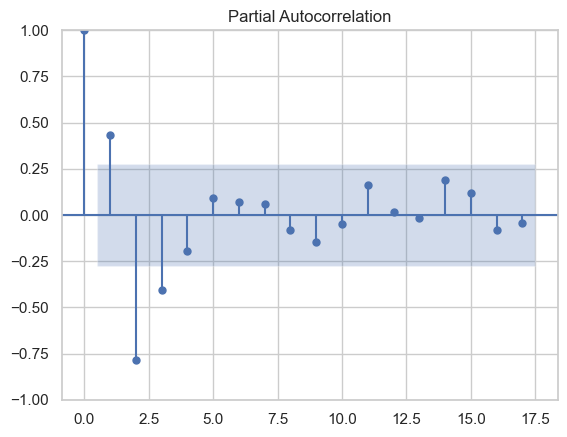

In [29]:
plot_pacf(df2);


In [32]:
# import ARIMA 
from statsmodels.tsa.arima.model import ARIMA
# fit model
# order (p, d, q)
model = ARIMA(df, order=(5,1,0))
results = model.fit()

/Users/andihaikalpalattui/Desktop/sample_machine/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andihaikalpalattui/Desktop/sample_machine/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/andihaikalpalattui/Desktop/sample_machine/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [34]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                 1018
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2570.557
Date:                Wed, 22 Nov 2023   AIC                           5153.113
Time:                        21:19:16   BIC                           5182.661
Sample:                    01-01-1939   HQIC                          5164.334
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0539      0.020     -2.628      0.009      -0.094      -0.014
ar.L2         -0.4232      0.022    -19.599      0.000      -0.466      -0.381
ar.L3         -0.5410      0.021    -26.236      0.0

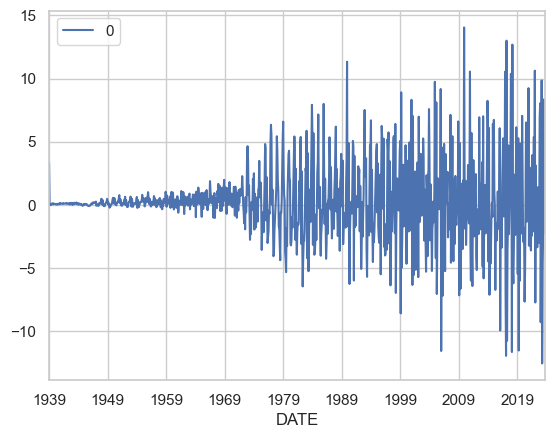

In [36]:
# plot residual errors
residuals = pd.DataFrame(results.resid)
residuals.plot();

<Axes: ylabel='Density'>

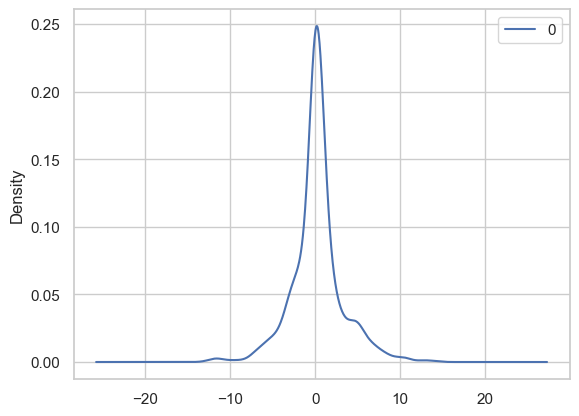

In [37]:
residuals.plot(kind='kde')

In [38]:
print(residuals.describe())

                 0
count  1018.000000
mean      0.249147
std       3.016958
min     -12.532712
25%      -0.832946
50%       0.121544
75%       1.102578
max      14.040888


## Grid search 


In [40]:
# Define the p, d and q parameters 
# In our example, we only take values between 0 and 2 to make the computation faster
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels.

The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [41]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61335D+00    |proj g|=  1.46994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   6.750D-09   5.613D+00
  F =   5.6133481948673802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11430.776924749985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.21417D+00    |proj g|=  2.51402D-02

At iterate   10    f=  4.96079D+00    |proj g|=  4.02276D-01

At iterate   15    f=  4.91011D+00    |proj g|=  7.49143D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     26      1     0     0   7.491D-06   4.910D+00
  F =   4.9101111074326660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10000.986214732908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   9.756D-06   2.454D+00
  F =   2.4543902147891257     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48668D+00    |proj g|=  4.84183D-01

At iterate    5    f=  2.43059D+00    |proj g|=  6.04194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final p

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4893.898366210028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40412D+00    |proj g|=  4.52375D-01

At iterate    5    f=  2.40207D+00    |proj g|=  1.47654D+00


 This problem is unconstrained.



At iterate   10    f=  2.38390D+00    |proj g|=  5.59312D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   2.687D-03   2.384D+00
  F =   2.3837025643296665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4859.218420975201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43254D+00    |proj g|=  4.69145D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54415D+00    |proj g|=  1.03066D+00

At iterate    5    f=  2.43116D+00    |proj g|=  5.42784D-03

At iterate   10    f=  2.43102D+00    |proj g|=  1.28561D-02

At iterate   15    f=  2.36414D+00    |proj g|=  2.32998D-01

At iterate   20    f=  2.36084D+00    |proj g|=  3.91513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     36      1     0     0   1.508D-05   2.361D+00
  F =   2.3608378723703423     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  4.98855D+00    |proj g|=  4.32137D+00

At iterate   20    f=  4.95650D+00    |proj g|=  3.90424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     33      1     0     0   2.242D-06   4.956D+00
  F =   4.9564708104431743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10095.374570062302


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53803D+00    |proj g|=  5.96913D-01

At iterate    5    f=  5.09034D+00    |proj g|=  2.77842D-02

At iterate   10    f=  5.07453D+00    |proj g|=  1.55285D-01

At iterate   15    f=  4.29665D+00    |proj g|=  1.13476D-01

At iterate   20    f=  4.29589D+00    |proj g|=  2.98093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     51      1     0     0   8.986D-06   4.296D+00
  F =   4.2958897980253106     

CONVERG

 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4659.954690482189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26726D+00    |proj g|=  1.64222D-01


 This problem is unconstrained.



At iterate    5    f=  2.25095D+00    |proj g|=  8.74885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.743D-06   2.251D+00
  F =   2.2509167819646869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4588.866568080102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51927D+00    |proj g|=  6.15281D-01



 This problem is unconstrained.


At iterate    5    f=  4.83714D+00    |proj g|=  7.56902D-01
  ys=-1.564E+00  -gs= 1.142E+00 BFGS update SKIPPED

At iterate   10    f=  2.79257D+00    |proj g|=  1.83453D+01

At iterate   15    f=  2.27444D+00    |proj g|=  3.57482D-01

At iterate   20    f=  2.25949D+00    |proj g|=  2.70259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     63      1     1     0   1.914D-04   2.259D+00
  F =   2.2594845272213337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4606.310497422635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.22


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.93704D+00    |proj g|=  8.15790D-02

At iterate   10    f=  4.68913D+00    |proj g|=  6.43344D-01

At iterate   15    f=  2.93614D+00    |proj g|=  3.78946D+00

At iterate   20    f=  2.22632D+00    |proj g|=  9.81006D-01

At iterate   25    f=  2.21293D+00    |proj g|=  2.64007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     68      1     0     0   3.073D-04   2.213D+00
  F =   2.2128617513444673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4513.386525737335
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  2.25533D+00    |proj g|=  4.19799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.980D-06   2.255D+00
  F =   2.2553302857587729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4597.852461804861


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29183D+00    |proj g|=  4.21672D-01

At iterate    5    f=  2.25470D+00    |proj g|=  4.78154D-02

At iterate   10    f=  2.25081D+00    |proj g|=  6.56644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.495D-06   2.251D+00
  F =   2.2508079581075817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4590.645002707036
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76666D+00    |proj g|=  3.11489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.627D-07   2.766D+00
  F =   2.7659197947497121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5635.412702110414


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32604D+00    |proj g|=  5.41088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   7.200D-07   2.326D+00
  F =   2.3259914624510389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4737.718617550316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4710.948409884073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15540D+00    |proj g|=  6.17886D-01


 This problem is unconstrained.



At iterate    5    f=  2.12541D+00    |proj g|=  4.66766D-01

At iterate   10    f=  2.11984D+00    |proj g|=  2.80507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   5.879D-06   2.120D+00
  F =   2.1198188220266867     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:4321.951121646334
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23195D+00    |proj g|=  5.02194D-06

           * *

 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4548.258760501412
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12361D+00    |proj g|=  1.06813D-01


 This problem is unconstrained.



At iterate    5    f=  2.11512D+00    |proj g|=  6.35502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   1.221D-04   2.114D+00
  F =   2.1143922749452062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4310.90267178844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08612D+00    |proj g|=  2.86923D-01

At iterate    5    f=  3.02278D+00    |proj g|=  2.59343D-02

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88379D+00    |proj g|=  2.46081D-01

At iterate    5    f=  2.72825D+00    |proj g|=  1.77928D-01

At iterate   10    f=  2.72306D+00    |proj g|=  9.37694D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.377D-07   2.723D+00
  F =   2.7230579046773298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:5550.145893923043
RUNNING THE L-B

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   9.646D-06   2.245D+00
  F =   2.2453809352858802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4575.595584242052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08774D+00    |proj g|=  1.21050D-01


 This problem is unconstrained.



At iterate    5    f=  2.05482D+00    |proj g|=  7.56963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   3.516D-06   2.055D+00
  F =   2.0548202731284428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:4189.61407608951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73170D+00    |proj g|=  1.35017D-01

At iterate    5    f=  2.24865D+00    |proj g|=  1.18113D-01



 This problem is unconstrained.


At iterate   10    f=  2.24030D+00    |proj g|=  1.73165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   3.475D-06   2.240D+00
  F =   2.2402930982448628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:4567.23674802654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69838D+00    |proj g|=  1.45566D-01


 This problem is unconstrained.



At iterate    5    f=  2.25099D+00    |proj g|=  6.53344D-01

At iterate   10    f=  2.10296D+00    |proj g|=  2.86971D-01

At iterate   15    f=  2.05874D+00    |proj g|=  1.52086D-01

At iterate   20    f=  2.05860D+00    |proj g|=  2.30032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   2.300D-04   2.059D+00
  F =   2.0586035001159457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:4199.316726236066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.16375D+00    |proj g|=  4.10223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.127D-05   2.164D+00
  F =   2.1637473820007895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:4411.389669753607


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08887D+00    |proj g|=  1.21786D-01

At iterate    5    f=  2.05636D+00    |proj g|=  5.59156D-03

At iterate   10    f=  2.05632D+00    |proj g|=  3.67865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.109D-05   2.056D+00
  F =   2.0563239461246439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:4194.675554309775
RUNNING THE L-B

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89954D+00    |proj g|=  4.73432D-01

At iterate    5    f=  2.86820D+00    |proj g|=  8.83852D-02

At iterate   10    f=  2.77002D+00    |proj g|=  1.31898D-01

At iterate   15    f=  2.76758D+00    |proj g|=  2.79828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   1.629D-05   2.768D+00
  F =   2.7675789998235154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:4527.774598445281
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14797D+00    |proj g|=  1.76949D-01

At iterate    5    f=  2.09613D+00    |proj g|=  2.17487D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.204D-06   2.096D+00
  F =   2.0960052301805643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:4273.466648647629
RUNNING THE L-BFGS-B C

 This problem is unconstrained.



At iterate    5    f=  2.30505D+00    |proj g|=  1.44226D+00

At iterate   10    f=  2.21430D+00    |proj g|=  6.96224D-01

At iterate   15    f=  2.21173D+00    |proj g|=  1.05250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     27      1     0     0   8.215D-06   2.212D+00
  F =   2.2117295486880333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:4509.081361128836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.52015D+00    |proj g|=  1.08856D+00

At iterate   10    f=  2.49096D+00    |proj g|=  2.38488D+00

At iterate   15    f=  2.17157D+00    |proj g|=  2.89225D+00

At iterate   20    f=  2.09468D+00    |proj g|=  1.73951D-01

At iterate   25    f=  2.09378D+00    |proj g|=  2.12860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     61      1     0     0   2.129D-04   2.094D+00
  F =   2.0937817874641360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:4270.939719276981



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19485D+00    |proj g|=  2.50202D-01

At iterate    5    f=  2.15311D+00    |proj g|=  2.53281D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   6.026D-06   2.153D+00
  F =   2.1531102820748336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:4389.732534304361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15304D+00    |proj g|=  2.56647D-01


 This problem is unconstrained.



At iterate    5    f=  2.09953D+00    |proj g|=  1.33256D-01

At iterate   10    f=  2.09612D+00    |proj g|=  8.19949D-03

At iterate   15    f=  2.09600D+00    |proj g|=  9.42419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.617D-06   2.096D+00
  F =   2.0960049705395383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:4275.4661200185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:6152.038193716103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91846D+00    |proj g|=  1.38291D+00


 This problem is unconstrained.



At iterate    5    f=  2.76717D+00    |proj g|=  3.29333D-01

At iterate   10    f=  2.74884D+00    |proj g|=  2.52165D-01

At iterate   15    f=  2.72407D+00    |proj g|=  1.33809D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.527D-05   2.724D+00
  F =   2.7240277310743171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5554.120460467309
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:4504.261533283117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12843D+00    |proj g|=  1.88292D-01


 This problem is unconstrained.



At iterate    5    f=  2.05810D+00    |proj g|=  6.44726D-02

At iterate   10    f=  2.05137D+00    |proj g|=  7.40547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.762D-06   2.051D+00
  F =   2.0512566930131442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:4184.358626974761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71364D+00    |proj g|=  4.92783D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  2.25656D+00    |proj g|=  6.12529D-01

At iterate   15    f=  2.20902D+00    |proj g|=  1.83365D-01

At iterate   20    f=  2.20578D+00    |proj g|=  4.04639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   3.904D-05   2.206D+00
  F =   2.2057770222995403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:4498.962017401864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.45423D+00    |proj g|=  1.79936D-01

At iterate   10    f=  2.36802D+00    |proj g|=  2.79451D-01

At iterate   15    f=  2.19762D+00    |proj g|=  5.16147D+00

At iterate   20    f=  2.07187D+00    |proj g|=  2.13763D-01

At iterate   25    f=  2.05664D+00    |proj g|=  2.57046D-01

At iterate   30    f=  2.05311D+00    |proj g|=  2.74780D-02

At iterate   35    f=  2.05304D+00    |proj g|=  1.86932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     58      1     0     0   1.503D-05   2.053D+00
  F =   2.0530429581391623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.13685D+00    |proj g|=  1.93542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.095D-05   2.137D+00
  F =   2.1368408418083717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:4358.6079539218445
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12865D+00    |proj g|=  2.74696D-01


 This problem is unconstrained.



At iterate    5    f=  2.05889D+00    |proj g|=  1.22413D-01

At iterate   10    f=  2.05185D+00    |proj g|=  1.34593D-01

At iterate   15    f=  2.05126D+00    |proj g|=  8.73255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   4.736D-04   2.051D+00
  F =   2.0512557755462622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:4186.356759012189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.74692D+00    |proj g|=  2.93230D-02

At iterate   10    f=  2.74649D+00    |proj g|=  2.52270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   2.523D-05   2.746D+00
  F =   2.7464883547370675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5597.85029024467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28552D+00    |proj g|=  5.42526D-06

           * * 

 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:4657.318611867984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11681D+00    |proj g|=  1.16238D-01


 This problem is unconstrained.



At iterate    5    f=  2.08761D+00    |proj g|=  8.38869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   7.613D-06   2.088D+00
  F =   2.0876108029369371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:4256.375594779604
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70300D+00    |proj g|=  1.34007D-01

At iterate    5    f=  2.40862D+00    |proj g|=  2.38823D-01

At iterate   1

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:4639.840127305964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66552D+00    |proj g|=  1.45929D-01


 This problem is unconstrained.



At iterate    5    f=  2.39889D+00    |proj g|=  9.21009D-01

At iterate   10    f=  2.14811D+00    |proj g|=  3.19567D-01

At iterate   15    f=  2.09042D+00    |proj g|=  3.70728D-02

At iterate   20    f=  2.09020D+00    |proj g|=  1.27892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.279D-05   2.090D+00
  F =   2.0902028867807214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4263.653077485549
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:4475.836839271586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11782D+00    |proj g|=  1.17016D-01


 This problem is unconstrained.



At iterate    5    f=  2.08836D+00    |proj g|=  1.37566D-01

At iterate   10    f=  2.08761D+00    |proj g|=  1.45888D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     20      1     0     0   1.459D-06   2.088D+00
  F =   2.0876102044852081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:4258.3743763318835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15981D+00    |proj g|=  1.30609D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89586D+00    |proj g|=  3.42407D-01

At iterate    5    f=  2.75827D+00    |proj g|=  1.80452D-01

At iterate   10    f=  2.72156D+00    |proj g|=  5.38858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.768D-07   2.722D+00
  F =   2.7215169924024445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5549.008596531377
RUNNING THE L-B

 This problem is unconstrained.



At iterate    5    f=  2.19437D+00    |proj g|=  4.71065D-02

At iterate   10    f=  2.19345D+00    |proj g|=  2.23218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   1.196D-05   2.193D+00
  F =   2.1934382382105628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:4471.840252996706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06352D+00    |proj g|=  1.35402D-01


 This problem is unconstrained.



At iterate    5    f=  2.00017D+00    |proj g|=  3.34154D-02

At iterate   10    f=  1.99981D+00    |proj g|=  7.34505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.897D-07   2.000D+00
  F =   1.9998086663666341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:4079.610444722467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67796D+00    |proj g|=  1.37122D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  2.19069D+00    |proj g|=  2.03206D-01

At iterate   15    f=  2.18438D+00    |proj g|=  1.69543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   5.619D-06   2.184D+00
  F =   2.1843754813138703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:4455.38847995504


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64132D+00    |proj g|=  1.50921D-01

At iterate    5    f=  2.41949D+00    |proj g|=  2.48546D-01

At iterate   10    f=  2.05929D+00    |proj g|=  7.74099D-02

At iterate   15    f=  2.02846D+00    |proj g|=  1.73592D-01

At iterate   20    f=  2.00838D+00    |proj g|=  2.21603D-02

At iterate   25    f=  2.00837D+00    |proj g|=  2.63516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     43      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.11067D+00    |proj g|=  2.67149D-02

At iterate   10    f=  2.11011D+00    |proj g|=  2.18755D-03

At iterate   15    f=  2.11011D+00    |proj g|=  7.65485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   7.655D-06   2.110D+00
  F =   2.1101144534231686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:4304.193027169571


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06449D+00    |proj g|=  1.36273D-01

At iterate    5    f=  2.00410D+00    |proj g|=  4.88358D-02

At iterate   10    f=  1.99987D+00    |proj g|=  1.12427D-02

At iterate   15    f=  1.99981D+00    |proj g|=  6.95708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     27      1     0     0   1.336D-05   2.000D+00
  F =   1.9998084993801479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

In [42]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61335D+00    |proj g|=  1.46994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   6.750D-09   5.613D+00
  F =   5.6133481948673802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11430.776924749985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22164D+00    |proj g|=  1.11706D-01


 This problem is unconstrained.



At iterate    5    f=  5.21417D+00    |proj g|=  2.51402D-02

At iterate   10    f=  4.96079D+00    |proj g|=  4.02276D-01

At iterate   15    f=  4.91011D+00    |proj g|=  7.49143D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     26      1     0     0   7.491D-06   4.910D+00
  F =   4.9101111074326660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10000.986214732908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4999.13847731066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48668D+00    |proj g|=  4.84183D-01


 This problem is unconstrained.



At iterate    5    f=  2.43059D+00    |proj g|=  6.04194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.805D-06   2.431D+00
  F =   2.4305875146323026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4952.676179791368
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40172D+00    |proj g|=  2.85114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4893.898366210028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40412D+00    |proj g|=  4.52375D-01


 This problem is unconstrained.



At iterate    5    f=  2.40207D+00    |proj g|=  1.47654D+00

At iterate   10    f=  2.38390D+00    |proj g|=  5.59312D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   2.687D-03   2.384D+00
  F =   2.3837025643296665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4859.218420975201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43254D+00    |proj g|=  4.69145D-06

           * *

 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4956.643114773462
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54415D+00    |proj g|=  1.03066D+00


 This problem is unconstrained.



At iterate    5    f=  2.43116D+00    |proj g|=  5.42784D-03

At iterate   10    f=  2.43102D+00    |proj g|=  1.28561D-02

At iterate   15    f=  2.36414D+00    |proj g|=  2.32998D-01

At iterate   20    f=  2.36084D+00    |proj g|=  3.91513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     36      1     0     0   1.508D-05   2.361D+00
  F =   2.3608378723703423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4812.665908146017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.



At iterate   20    f=  4.95650D+00    |proj g|=  3.90424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     33      1     0     0   2.242D-06   4.956D+00
  F =   4.9564708104431743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10095.374570062302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53803D+00    |proj g|=  5.96913D-01


 This problem is unconstrained.



At iterate    5    f=  5.09034D+00    |proj g|=  2.77842D-02

At iterate   10    f=  5.07453D+00    |proj g|=  1.55285D-01

At iterate   15    f=  4.29665D+00    |proj g|=  1.13476D-01

At iterate   20    f=  4.29589D+00    |proj g|=  2.98093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     51      1     0     0   8.986D-06   4.296D+00
  F =   4.2958897980253106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8752.431628779532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4659.954690482189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26726D+00    |proj g|=  1.64222D-01


 This problem is unconstrained.



At iterate    5    f=  2.25095D+00    |proj g|=  8.74885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.743D-06   2.251D+00
  F =   2.2509167819646869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4588.866568080102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.51927D+00    |proj g|=  6.15281D-01

At iterate    5    f=  4.83714D+00    |proj g|=  7.56902D-01


 This problem is unconstrained.


  ys=-1.564E+00  -gs= 1.142E+00 BFGS update SKIPPED

At iterate   10    f=  2.79257D+00    |proj g|=  1.83453D+01

At iterate   15    f=  2.27444D+00    |proj g|=  3.57482D-01

At iterate   20    f=  2.25949D+00    |proj g|=  2.70259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     63      1     1     0   1.914D-04   2.259D+00
  F =   2.2594845272213337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4606.310497422635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.93704D+00    |proj g|=  8.15790D-02

At iterate   10    f=  4.68913D+00    |proj g|=  6.43344D-01

At iterate   15    f=  2.93614D+00    |proj g|=  3.78946D+00

At iterate   20    f=  2.22632D+00    |proj g|=  9.81006D-01

At iterate   25    f=  2.21293D+00    |proj g|=  2.64007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     68      1     0     0   3.073D-04   2.213D+00
  F =   2.2128617513444673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4513.386525737335
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  2.25533D+00    |proj g|=  4.19799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.980D-06   2.255D+00
  F =   2.2553302857587729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4597.852461804861
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29183D+00    |proj g|=  4.21672D-01


 This problem is unconstrained.



At iterate    5    f=  2.25470D+00    |proj g|=  4.78154D-02

At iterate   10    f=  2.25081D+00    |proj g|=  6.56644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.495D-06   2.251D+00
  F =   2.2508079581075817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4590.645002707036
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15909D+00    |proj g|=  3.42675D-04

           * *

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6433.8967694893945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92715D+00    |proj g|=  2.98680D-01

At iterate    5    f=  2.76666D+00    |proj g|=  3.11489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.627D-07   2.766D+00
  F =   2.7659197947497121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5635.412702110414
RUNNING THE L-BFGS-B 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   7.200D-07   2.326D+00
  F =   2.3259914624510389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4737.718617550316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12316D+00    |proj g|=  1.25463D-01

At iterate    5    f=  2.11439D+00    |proj g|=  8.36677D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4710.948409884073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15540D+00    |proj g|=  6.17886D-01


 This problem is unconstrained.



At iterate    5    f=  2.12541D+00    |proj g|=  4.66766D-01

At iterate   10    f=  2.11984D+00    |proj g|=  2.80507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   5.879D-06   2.120D+00
  F =   2.1198188220266867     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:4321.951121646334
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23195D+00    |proj g|=  5.02194D-06

           * *

 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4548.258760501412
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12361D+00    |proj g|=  1.06813D-01


 This problem is unconstrained.



At iterate    5    f=  2.11512D+00    |proj g|=  6.35502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   1.221D-04   2.114D+00
  F =   2.1143922749452062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4310.90267178844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08612D+00    |proj g|=  2.86923D-01

At iterate    5    f=  3.02278D+00    |proj g|=  2.59343D-02

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88379D+00    |proj g|=  2.46081D-01

At iterate    5    f=  2.72825D+00    |proj g|=  1.77928D-01

At iterate   10    f=  2.72306D+00    |proj g|=  9.37694D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.377D-07   2.723D+00
  F =   2.7230579046773298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:5550.145893923043
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4575.595584242052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08774D+00    |proj g|=  1.21050D-01

At iterate    5    f=  2.05482D+00    |proj g|=  7.56963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   3.516D-06   2.055D+00
  F =   2.0548202731284428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:4189.61407608951
RUNNING THE L-BFGS-B CO

 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:4567.23674802654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69838D+00    |proj g|=  1.45566D-01


 This problem is unconstrained.



At iterate    5    f=  2.25099D+00    |proj g|=  6.53344D-01

At iterate   10    f=  2.10296D+00    |proj g|=  2.86971D-01

At iterate   15    f=  2.05874D+00    |proj g|=  1.52086D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  2.05860D+00    |proj g|=  2.30032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   2.300D-04   2.059D+00
  F =   2.0586035001159457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:4199.316726236066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17313D+00    |proj g|=  6.10601D-02

At iterate    5    f=  2.16375D+00    |proj g|=  4.10223D-05

           * *

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08887D+00    |proj g|=  1.21786D-01

At iterate    5    f=  2.05636D+00    |proj g|=  5.59156D-03

At iterate   10    f=  2.05632D+00    |proj g|=  3.67865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.109D-05   2.056D+00
  F =   2.0563239461246439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:4194.675554309775
RUNNING THE L-B

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.86820D+00    |proj g|=  8.83852D-02

At iterate   10    f=  2.77002D+00    |proj g|=  1.31898D-01

At iterate   15    f=  2.76758D+00    |proj g|=  2.79828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   1.629D-05   2.768D+00
  F =   2.7675789998235154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:5640.790843640677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.09613D+00    |proj g|=  2.17487D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.204D-06   2.096D+00
  F =   2.0960052301805643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:4273.466648647629
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72961D+00    |proj g|=  1.37670D-01

At iterate    5    f=  2.30505D+00    |proj g|=  1.44226D+00

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  2.21173D+00    |proj g|=  1.05250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     27      1     0     0   8.215D-06   2.212D+00
  F =   2.2117295486880333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:4509.081361128836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71000D+00    |proj g|=  1.44804D-01


 This problem is unconstrained.



At iterate    5    f=  2.52015D+00    |proj g|=  1.08856D+00

At iterate   10    f=  2.49096D+00    |proj g|=  2.38488D+00

At iterate   15    f=  2.17157D+00    |proj g|=  2.89225D+00

At iterate   20    f=  2.09468D+00    |proj g|=  1.73951D-01

At iterate   25    f=  2.09378D+00    |proj g|=  2.12860D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     61      1     0     0   2.129D-04   2.094D+00
  F =   2.0937817874641360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:4270.939719276981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19485D+00    |proj g|=  2.50202D-01

At iterate    5    f=  2.15311D+00    |proj g|=  2.53281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15304D+00    |proj g|=  2.56647D-01

At iterate    5    f=  2.09953D+00    |proj g|=  1.33256D-01

At iterate   10    f=  2.09612D+00    |proj g|=  8.19949D-03

At iterate   15    f=  2.09600D+00    |proj g|=  9.42419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.617D-06   2.096D+00
  F =   2.0960049705395383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1,

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76717D+00    |proj g|=  3.29333D-01

At iterate   10    f=  2.74884D+00    |proj g|=  2.52165D-01

At iterate   15    f=  2.72407D+00    |proj g|=  1.33809D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.527D-05   2.724D+00
  F =   2.7240277310743171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5554.120460467309
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   5.004D-06   2.209D+00
  F =   2.2093622462097824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:4504.261533283117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12843D+00    |proj g|=  1.88292D-01


 This problem is unconstrained.



At iterate    5    f=  2.05810D+00    |proj g|=  6.44726D-02

At iterate   10    f=  2.05137D+00    |proj g|=  7.40547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.762D-06   2.051D+00
  F =   2.0512566930131442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:4184.358626974761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71364D+00    |proj g|=  4.92783D-01


 This problem is unconstrained.



At iterate    5    f=  2.46850D+00    |proj g|=  1.65494D-01

At iterate   10    f=  2.25656D+00    |proj g|=  6.12529D-01

At iterate   15    f=  2.20902D+00    |proj g|=  1.83365D-01

At iterate   20    f=  2.20578D+00    |proj g|=  4.04639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   3.904D-05   2.206D+00
  F =   2.2057770222995403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:4498.962017401864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  2.45423D+00    |proj g|=  1.79936D-01

At iterate   10    f=  2.36802D+00    |proj g|=  2.79451D-01

At iterate   15    f=  2.19762D+00    |proj g|=  5.16147D+00

At iterate   20    f=  2.07187D+00    |proj g|=  2.13763D-01

At iterate   25    f=  2.05664D+00    |proj g|=  2.57046D-01

At iterate   30    f=  2.05311D+00    |proj g|=  2.74780D-02

At iterate   35    f=  2.05304D+00    |proj g|=  1.86932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     58      1     0     0   1.503D-05   2.053D+00
  F =   2.0530429581391623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.13685D+00    |proj g|=  1.93542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.095D-05   2.137D+00
  F =   2.1368408418083717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:4358.6079539218445


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12865D+00    |proj g|=  2.74696D-01

At iterate    5    f=  2.05889D+00    |proj g|=  1.22413D-01

At iterate   10    f=  2.05185D+00    |proj g|=  1.34593D-01

At iterate   15    f=  2.05126D+00    |proj g|=  8.73255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   4.736D-04   2.051D+00
  F =   2.0512557755462622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1,

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.74692D+00    |proj g|=  2.93230D-02

At iterate   10    f=  2.74649D+00    |proj g|=  2.52270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   2.523D-05   2.746D+00
  F =   2.7464883547370675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5597.85029024467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28552D+00    |proj g|=  5.42526D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.08761D+00    |proj g|=  8.38869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   7.613D-06   2.088D+00
  F =   2.0876108029369371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:4256.375594779604
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70300D+00    |proj g|=  1.34007D-01

At iterate    5    f=  2.40862D+00    |proj g|=  2.38823D-01

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:4639.840127305964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66552D+00    |proj g|=  1.45929D-01

At iterate    5    f=  2.39889D+00    |proj g|=  9.21009D-01

At iterate   10    f=  2.14811D+00    |proj g|=  3.19567D-01

At iterate   15    f=  2.09042D+00    |proj g|=  3.70728D-02

At iterate   20    f=  2.09020D+00    |proj g|=  1.27892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.279D-

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:4475.836839271586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11782D+00    |proj g|=  1.17016D-01


 This problem is unconstrained.



At iterate    5    f=  2.08836D+00    |proj g|=  1.37566D-01

At iterate   10    f=  2.08761D+00    |proj g|=  1.45888D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     20      1     0     0   1.459D-06   2.088D+00
  F =   2.0876102044852081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:4258.3743763318835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15981D+00    |proj g|=  1.30609D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89586D+00    |proj g|=  3.42407D-01

At iterate    5    f=  2.75827D+00    |proj g|=  1.80452D-01

At iterate   10    f=  2.72156D+00    |proj g|=  5.38858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.768D-07   2.722D+00
  F =   2.7215169924024445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5549.008596531377
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  2.19437D+00    |proj g|=  4.71065D-02

At iterate   10    f=  2.19345D+00    |proj g|=  2.23218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   1.196D-05   2.193D+00
  F =   2.1934382382105628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:4471.840252996706


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06352D+00    |proj g|=  1.35402D-01

At iterate    5    f=  2.00017D+00    |proj g|=  3.34154D-02

At iterate   10    f=  1.99981D+00    |proj g|=  7.34505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.897D-07   2.000D+00
  F =   1.9998086663666341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:4079.610444722467
RUNNING THE L-B

 This problem is unconstrained.



At iterate   10    f=  2.19069D+00    |proj g|=  2.03206D-01

At iterate   15    f=  2.18438D+00    |proj g|=  1.69543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   5.619D-06   2.184D+00
  F =   2.1843754813138703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:4455.38847995504
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64132D+00    |proj g|=  1.50921D-01


 This problem is unconstrained.



At iterate    5    f=  2.41949D+00    |proj g|=  2.48546D-01

At iterate   10    f=  2.05929D+00    |proj g|=  7.74099D-02

At iterate   15    f=  2.02846D+00    |proj g|=  1.73592D-01

At iterate   20    f=  2.00838D+00    |proj g|=  2.21603D-02

At iterate   25    f=  2.00837D+00    |proj g|=  2.63516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     43      1     0     0   2.635D-05   2.008D+00
  F =   2.0083678723976091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:4099.036988201532
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  2.11067D+00    |proj g|=  2.67149D-02

At iterate   10    f=  2.11011D+00    |proj g|=  2.18755D-03

At iterate   15    f=  2.11011D+00    |proj g|=  7.65485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   7.655D-06   2.110D+00
  F =   2.1101144534231686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:4304.193027169571
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.00410D+00    |proj g|=  4.88358D-02

At iterate   10    f=  1.99987D+00    |proj g|=  1.12427D-02

At iterate   15    f=  1.99981D+00    |proj g|=  6.95708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     27      1     0     0   1.336D-05   2.000D+00
  F =   1.9998084993801479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:4081.610104737981


In [43]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.61335D+00    |proj g|=  1.46994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   6.750D-09   5.613D+00
  F =   5.6133481948673802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11430.776924749985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.21417D+00    |proj g|=  2.51402D-02

At iterate   10    f=  4.96079D+00    |proj g|=  4.02276D-01

At iterate   15    f=  4.91011D+00    |proj g|=  7.49143D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     26      1     0     0   7.491D-06   4.910D+00
  F =   4.9101111074326660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10000.986214732908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4999.13847731066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48668D+00    |proj g|=  4.84183D-01

At iterate    5    f=  2.43059D+00    |proj g|=  6.04194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.805D-06   2.431D+00
  F =   2.4305875146323026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4952.676179791368


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40172D+00    |proj g|=  2.85114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   2.851D-03   2.402D+00
  F =   2.4017182545235896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4893.898366210028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.



At iterate   10    f=  2.38390D+00    |proj g|=  5.59312D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   2.687D-03   2.384D+00
  F =   2.3837025643296665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4859.218420975201
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43254D+00    |proj g|=  4.69145D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4956.643114773462
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54415D+00    |proj g|=  1.03066D+00


 This problem is unconstrained.



At iterate    5    f=  2.43116D+00    |proj g|=  5.42784D-03

At iterate   10    f=  2.43102D+00    |proj g|=  1.28561D-02

At iterate   15    f=  2.36414D+00    |proj g|=  2.32998D-01

At iterate   20    f=  2.36084D+00    |proj g|=  3.91513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     36      1     0     0   1.508D-05   2.361D+00
  F =   2.3608378723703423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4812.665908146017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10095.374570062302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53803D+00    |proj g|=  5.96913D-01


 This problem is unconstrained.



At iterate    5    f=  5.09034D+00    |proj g|=  2.77842D-02

At iterate   10    f=  5.07453D+00    |proj g|=  1.55285D-01

At iterate   15    f=  4.29665D+00    |proj g|=  1.13476D-01

At iterate   20    f=  4.29589D+00    |proj g|=  2.98093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     51      1     0     0   8.986D-06   4.296D+00
  F =   4.2958897980253106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8752.431628779532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  2.28681D+00    |proj g|=  2.70983D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.710D-06   2.287D+00
  F =   2.2868146809833934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4659.954690482189


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26726D+00    |proj g|=  1.64222D-01

At iterate    5    f=  2.25095D+00    |proj g|=  8.74885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   6.743D-06   2.251D+00
  F =   2.2509167819646869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4588.866568080102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.


  ys=-1.564E+00  -gs= 1.142E+00 BFGS update SKIPPED

At iterate   10    f=  2.79257D+00    |proj g|=  1.83453D+01

At iterate   15    f=  2.27444D+00    |proj g|=  3.57482D-01

At iterate   20    f=  2.25949D+00    |proj g|=  2.70259D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     63      1     1     0   1.914D-04   2.259D+00
  F =   2.2594845272213337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4606.310497422635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  4.93704D+00    |proj g|=  8.15790D-02

At iterate   10    f=  4.68913D+00    |proj g|=  6.43344D-01

At iterate   15    f=  2.93614D+00    |proj g|=  3.78946D+00

At iterate   20    f=  2.22632D+00    |proj g|=  9.81006D-01

At iterate   25    f=  2.21293D+00    |proj g|=  2.64007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     68      1     0     0   3.073D-04   2.213D+00
  F =   2.2128617513444673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4513.386525737335
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  2.25533D+00    |proj g|=  4.19799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.980D-06   2.255D+00
  F =   2.2553302857587729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4597.852461804861
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29183D+00    |proj g|=  4.21672D-01


 This problem is unconstrained.



At iterate    5    f=  2.25470D+00    |proj g|=  4.78154D-02

At iterate   10    f=  2.25081D+00    |proj g|=  6.56644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.495D-06   2.251D+00
  F =   2.2508079581075817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4590.645002707036
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15909D+00    |proj g|=  3.42675D-04

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.76666D+00    |proj g|=  3.11489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.627D-07   2.766D+00
  F =   2.7659197947497121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:5635.412702110414


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32604D+00    |proj g|=  5.41088D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   7.200D-07   2.326D+00
  F =   2.3259914624510389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4737.718617550316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      9      1     0     0   2.516D-05   2.312D+00
  F =   2.3118607121238082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4710.948409884073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15540D+00    |proj g|=  6.17886D-01

At iterate    5    f=  2.12541D+00    |proj g|=  4.66766D-01

At iterate   10    f=  2.11984D+00    |proj g|=  2.80507D-02

           * *

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12361D+00    |proj g|=  1.06813D-01

At iterate    5    f=  2.11512D+00    |proj g|=  6.35502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   1.221D-04   2.114D+00
  F =   2.1143922749452062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:4310.90267178844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.72825D+00    |proj g|=  1.77928D-01

At iterate   10    f=  2.72306D+00    |proj g|=  9.37694D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   9.377D-07   2.723D+00
  F =   2.7230579046773298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:5550.145893923043


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25235D+00    |proj g|=  8.99875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   9.646D-06   2.245D+00
  F =   2.2453809352858802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4575.595584242052


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08774D+00    |proj g|=  1.21050D-01

At iterate    5    f=  2.05482D+00    |proj g|=  7.56963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   3.516D-06   2.055D+00
  F =   2.0548202731284428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:4189.61407608951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N 

 This problem is unconstrained.


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:4567.23674802654
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69838D+00    |proj g|=  1.45566D-01


 This problem is unconstrained.



At iterate    5    f=  2.25099D+00    |proj g|=  6.53344D-01

At iterate   10    f=  2.10296D+00    |proj g|=  2.86971D-01

At iterate   15    f=  2.05874D+00    |proj g|=  1.52086D-01

At iterate   20    f=  2.05860D+00    |proj g|=  2.30032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   2.300D-04   2.059D+00
  F =   2.0586035001159457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:4199.316726236066



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17313D+00    |proj g|=  6.10601D-02


 This problem is unconstrained.



At iterate    5    f=  2.16375D+00    |proj g|=  4.10223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.127D-05   2.164D+00
  F =   2.1637473820007895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:4411.389669753607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08887D+00    |proj g|=  1.21786D-01


 This problem is unconstrained.



At iterate    5    f=  2.05636D+00    |proj g|=  5.59156D-03

At iterate   10    f=  2.05632D+00    |proj g|=  3.67865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.109D-05   2.056D+00
  F =   2.0563239461246439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:4194.675554309775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16120D+00    |proj g|=  6.75605D-04

           * *

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:6440.209884997118
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89954D+00    |proj g|=  4.73432D-01


 This problem is unconstrained.



At iterate    5    f=  2.86820D+00    |proj g|=  8.83852D-02

At iterate   10    f=  2.77002D+00    |proj g|=  1.31898D-01

At iterate   15    f=  2.76758D+00    |proj g|=  2.79828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   1.629D-05   2.768D+00
  F =   2.7675789998235154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:5640.790843640677


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22189D+00    |proj g|=  7.99436D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.994D-06   2.222D+00
  F =   2.2218932212403151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:4527.774598445281
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.



At iterate   10    f=  2.21430D+00    |proj g|=  6.96224D-01

At iterate   15    f=  2.21173D+00    |proj g|=  1.05250D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     27      1     0     0   8.215D-06   2.212D+00
  F =   2.2117295486880333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:4509.081361128836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71000D+00    |proj g|=  1.44804D-01


 This problem is unconstrained.



At iterate    5    f=  2.52015D+00    |proj g|=  1.08856D+00

At iterate   10    f=  2.49096D+00    |proj g|=  2.38488D+00

At iterate   15    f=  2.17157D+00    |proj g|=  2.89225D+00

At iterate   20    f=  2.09468D+00    |proj g|=  1.73951D-01

At iterate   25    f=  2.09378D+00    |proj g|=  2.12860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     61      1     0     0   2.129D-04   2.094D+00
  F =   2.0937817874641360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:4270.939719276981
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.15311D+00    |proj g|=  2.53281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   6.026D-06   2.153D+00
  F =   2.1531102820748336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:4389.732534304361
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15304D+00    |proj g|=  2.56647D-01


 This problem is unconstrained.



At iterate    5    f=  2.09953D+00    |proj g|=  1.33256D-01

At iterate   10    f=  2.09612D+00    |proj g|=  8.19949D-03

At iterate   15    f=  2.09600D+00    |proj g|=  9.42419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.617D-06   2.096D+00
  F =   2.0960049705395383     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:4275.4661200185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91846D+00    |proj g|=  1.38291D+00

At iterate    5    f=  2.76717D+00    |proj g|=  3.29333D-01


 This problem is unconstrained.



At iterate   10    f=  2.74884D+00    |proj g|=  2.52165D-01

At iterate   15    f=  2.72407D+00    |proj g|=  1.33809D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.527D-05   2.724D+00
  F =   2.7240277310743171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:5554.120460467309
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21029D+00    |proj g|=  2.22939D-02

At iterate    

 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:4504.261533283117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12843D+00    |proj g|=  1.88292D-01


 This problem is unconstrained.



At iterate    5    f=  2.05810D+00    |proj g|=  6.44726D-02

At iterate   10    f=  2.05137D+00    |proj g|=  7.40547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.762D-06   2.051D+00
  F =   2.0512566930131442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:4184.358626974761
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71364D+00    |proj g|=  4.92783D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  2.25656D+00    |proj g|=  6.12529D-01

At iterate   15    f=  2.20902D+00    |proj g|=  1.83365D-01

At iterate   20    f=  2.20578D+00    |proj g|=  4.04639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   3.904D-05   2.206D+00
  F =   2.2057770222995403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:4498.962017401864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.45423D+00    |proj g|=  1.79936D-01

At iterate   10    f=  2.36802D+00    |proj g|=  2.79451D-01

At iterate   15    f=  2.19762D+00    |proj g|=  5.16147D+00

At iterate   20    f=  2.07187D+00    |proj g|=  2.13763D-01

At iterate   25    f=  2.05664D+00    |proj g|=  2.57046D-01

At iterate   30    f=  2.05311D+00    |proj g|=  2.74780D-02

At iterate   35    f=  2.05304D+00    |proj g|=  1.86932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     58      1     0     0   1.503D-05   2.053D+00
  F =   2.0530429581391623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.13685D+00    |proj g|=  1.93542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.095D-05   2.137D+00
  F =   2.1368408418083717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:4358.6079539218445
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12865D+00    |proj g|=  2.74696D-01


 This problem is unconstrained.



At iterate    5    f=  2.05889D+00    |proj g|=  1.22413D-01

At iterate   10    f=  2.05185D+00    |proj g|=  1.34593D-01

At iterate   15    f=  2.05126D+00    |proj g|=  8.73255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   4.736D-04   2.051D+00
  F =   2.0512557755462622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:4186.356759012189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86975D+00    |proj g|=  2.66190D-01

At iterate    5    f=  2.74692D+00    |proj g|=  2.93230D-02

At iterate   10    f=  2.74649D+00    |proj g|=  2.52270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   2.523D-05   2.746D+00
  F =   2.7464883547370675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:5597.85029024467


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28552D+00    |proj g|=  5.42526D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.425D-06   2.286D+00
  F =   2.2855199468899725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:4657.318611867984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:4639.840127305964
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66552D+00    |proj g|=  1.45929D-01


 This problem is unconstrained.



At iterate    5    f=  2.39889D+00    |proj g|=  9.21009D-01

At iterate   10    f=  2.14811D+00    |proj g|=  3.19567D-01

At iterate   15    f=  2.09042D+00    |proj g|=  3.70728D-02

At iterate   20    f=  2.09020D+00    |proj g|=  1.27892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.279D-05   2.090D+00
  F =   2.0902028867807214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:4263.653077485549
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:4475.836839271586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11782D+00    |proj g|=  1.17016D-01


 This problem is unconstrained.



At iterate    5    f=  2.08836D+00    |proj g|=  1.37566D-01

At iterate   10    f=  2.08761D+00    |proj g|=  1.45888D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     20      1     0     0   1.459D-06   2.088D+00
  F =   2.0876102044852081     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:4258.3743763318835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15981D+00    |proj g|=  1.30609D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89586D+00    |proj g|=  3.42407D-01

At iterate    5    f=  2.75827D+00    |proj g|=  1.80452D-01

At iterate   10    f=  2.72156D+00    |proj g|=  5.38858D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.768D-07   2.722D+00
  F =   2.7215169924024445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:5549.008596531377
RUNNING THE L-B

 This problem is unconstrained.



At iterate    5    f=  2.19437D+00    |proj g|=  4.71065D-02

At iterate   10    f=  2.19345D+00    |proj g|=  2.23218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   1.196D-05   2.193D+00
  F =   2.1934382382105628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:4471.840252996706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06352D+00    |proj g|=  1.35402D-01

At iterate    5    f=  2.00017D+00    |proj g|=  3.34154D-02

At iterate   10    f=  1.99981D+00    |proj g|=  7.34505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   8.897D-07   2.000D+00
  F =   1.9998086663666341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:4079.610444722467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           

 This problem is unconstrained.



At iterate   10    f=  2.19069D+00    |proj g|=  2.03206D-01

At iterate   15    f=  2.18438D+00    |proj g|=  1.69543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   5.619D-06   2.184D+00
  F =   2.1843754813138703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:4455.38847995504


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64132D+00    |proj g|=  1.50921D-01

At iterate    5    f=  2.41949D+00    |proj g|=  2.48546D-01

At iterate   10    f=  2.05929D+00    |proj g|=  7.74099D-02

At iterate   15    f=  2.02846D+00    |proj g|=  1.73592D-01

At iterate   20    f=  2.00838D+00    |proj g|=  2.21603D-02

At iterate   25    f=  2.00837D+00    |proj g|=  2.63516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     43      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  2.11067D+00    |proj g|=  2.67149D-02

At iterate   10    f=  2.11011D+00    |proj g|=  2.18755D-03

At iterate   15    f=  2.11011D+00    |proj g|=  7.65485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   7.655D-06   2.110D+00
  F =   2.1101144534231686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:4304.193027169571
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.00410D+00    |proj g|=  4.88358D-02

At iterate   10    f=  1.99987D+00    |proj g|=  1.12427D-02

At iterate   15    f=  1.99981D+00    |proj g|=  6.95708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     27      1     0     0   1.336D-05   2.000D+00
  F =   1.9998084993801479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:4081.610104737981


In [44]:
results.aic

4081.610104737981

In [45]:
mod = smf.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06449D+00    |proj g|=  1.36273D-01

At iterate    5    f=  2.00410D+00    |proj g|=  4.88358D-02

At iterate   10    f=  1.99987D+00    |proj g|=  1.12427D-02

At iterate   15    f=  1.99981D+00    |proj g|=  6.95708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     27      1     0     0   1.336D-05   2.000D+00
  F =   1.9998084993801479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|

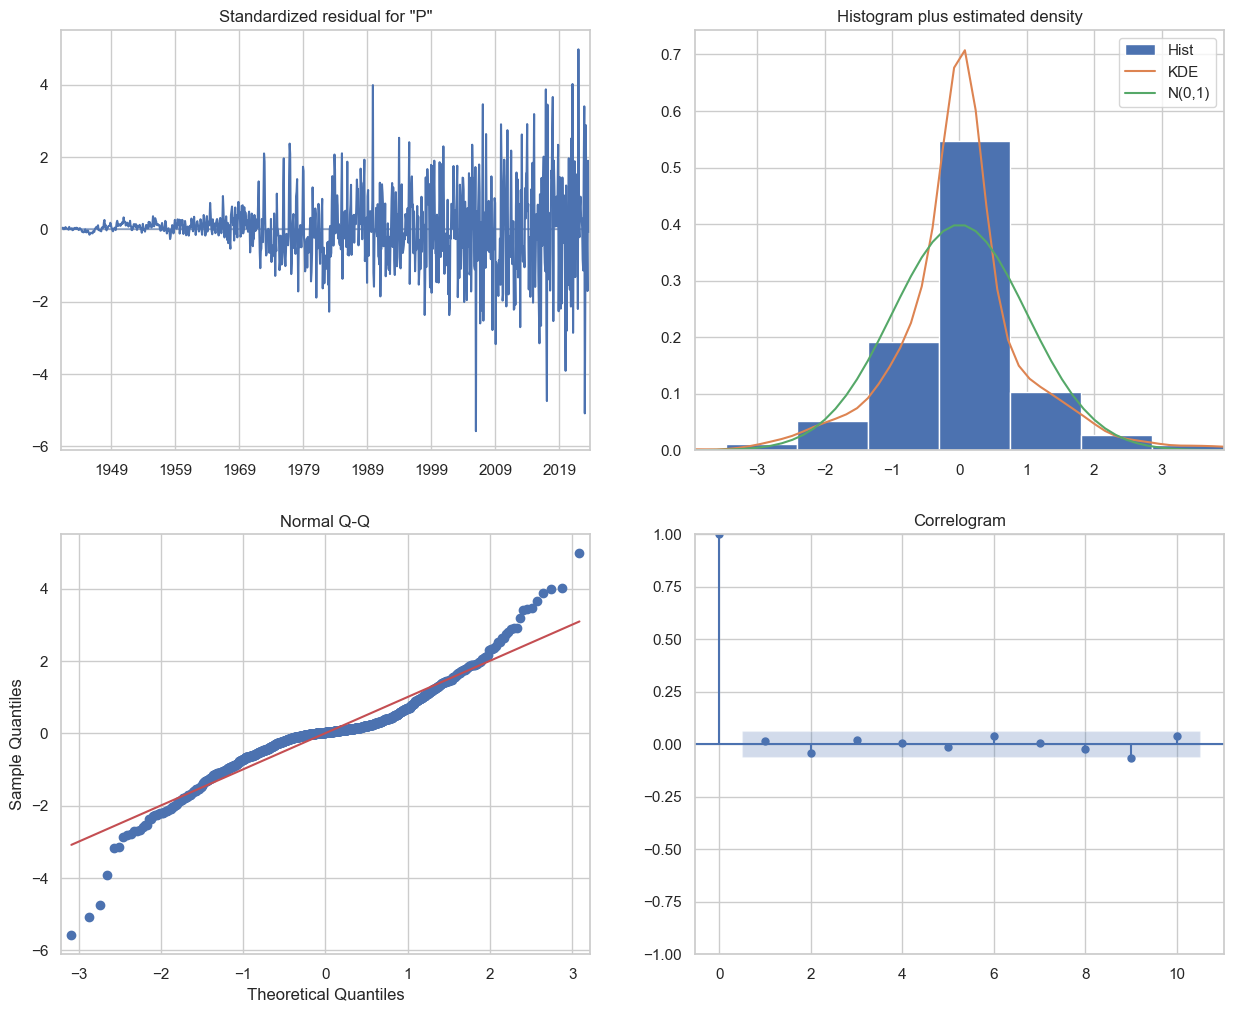

In [46]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Forecasts

In [47]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at January 2017.

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the energy production time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

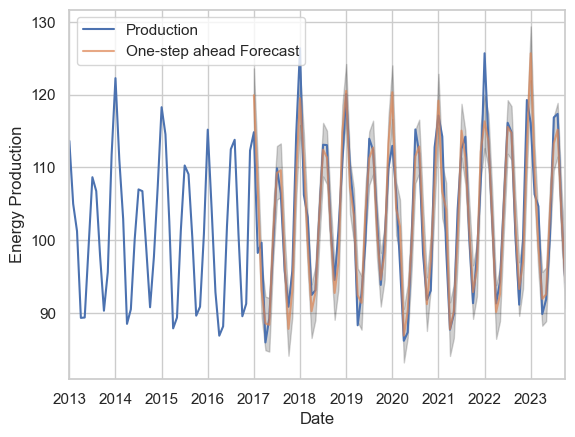

In [48]:
ax = df['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Energy Production')
plt.legend()

plt.show()

Overall, our forecasts align with the true values relatively well.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

## Model Accuracy : Mean squared error (MSE)

In [49]:
# Forecasts
df['y_forecasted'] = pred.predicted_mean
df['error_sq_2'] = (df['Production'] - pred.predicted_mean)**2
# Drop NAs and generate new DataFrame
df_pred = df.dropna()
# Sum of squared residuals (SS_R)
SS_R = df_pred['error_sq_2'].sum()
# calculate mean squared error of the model:
# Number of obeservations (lenght of DataFrame)
n = len(df_pred["error_sq_2"])
# calculate mse
mse = round((SS_R/(n-1)),2)
# print output
print('Mean squared error:', mse)

Mean squared error: 12.72


In [50]:
df_pred.head(5)

,Production,y_forecasted,error_sq_2
DATE,,,
2017-01-01,114.8147,119.899278,25.852931
2017-02-01,98.2106,107.156349,80.026419
2017-03-01,99.6345,93.146660,42.092066
2017-04-01,85.9082,88.522015,6.832027
2017-05-01,89.2046,88.335081,0.756063
